## Домашняя работа - Бинарная классификация

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [40]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [41]:
data = pd.read_csv('data.adult.csv')

In [42]:
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16280 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16280 non-null  int64 
 1   workclass       16280 non-null  object
 2   fnlwgt          16280 non-null  int64 
 3   education       16280 non-null  object
 4   education-num   16280 non-null  int64 
 5   marital-status  16280 non-null  object
 6   occupation      16280 non-null  object
 7   relationship    16280 non-null  object
 8   race            16280 non-null  object
 9   sex             16280 non-null  object
 10  capital-gain    16280 non-null  int64 
 11  capital-loss    16280 non-null  int64 
 12  hours-per-week  16280 non-null  int64 
 13  >50K,<=50K      16280 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.7+ MB


Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**(0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [44]:
# Аналонично с ДЗ-3 посчитаем пропуски, заменим на np.nan, удалим объекты с пропусками
data.isin(['?']).sum()

age                 0
workclass         929
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        933
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
>50K,<=50K          0
dtype: int64

In [45]:
# ? заменим на NaN и удалим пропуски
data[data.columns.tolist()] = data[data.columns.tolist()].replace('?', np.nan)
data = data.dropna()

In [46]:
# Проверка
data.isin(['?']).sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
>50K,<=50K        0
dtype: int64



</font><font color='Blue'><b>Все пропуски удалены.</b></font><br>

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [47]:
# Приведем целевую переменную к бинарному виду
data['>50K,<=50K'] = data['>50K,<=50K'].apply(lambda x: 1 if x=='>50K' else 0)

In [48]:
# Выделим отдельно целевую переменную
target = data['>50K,<=50K']

# Удалим столбец с целевой переменной из датасета
data = data.drop('>50K,<=50K', axis=1)

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - kNN
 - SGD Linear Classifier
 - Naive Bayes Classifier
 - Logistic Regression
 - SVC (Support Vector Classifier)
 
Для начала у первых двух алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе GridSearchCV. В качестве схемы кросс-валидации используйте 5-fold cv.

**(1.5 балла)** Для каждого из первых двух алгоритмов подберите оптимальные значения указанных гиперпараметров. Постройте график среднего качества по кросс-валидации алгоритма при заданном значении гиперпараметра, на котором также отобразите доверительный интервал (доверительный интервал задается границами [mean - std, mean + std]).

In [49]:
# Выделим вещественные признаки
num_data = data.select_dtypes(include=[np.number])

In [50]:
num_data

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


In [51]:
# Определим фичи и целевую переменную
X = num_data
y = target

# KNN и GridSearch

In [52]:
# Pipeline и GridSearchCV для kNN
knn_pipe = Pipeline([('knn', KNeighborsClassifier())])
knn_params = {'knn__n_neighbors': range(1, 31)}

In [53]:
knn_grid = GridSearchCV(knn_pipe, 
                        knn_params, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        return_train_score=True)
knn_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 31)},
             return_train_score=True)

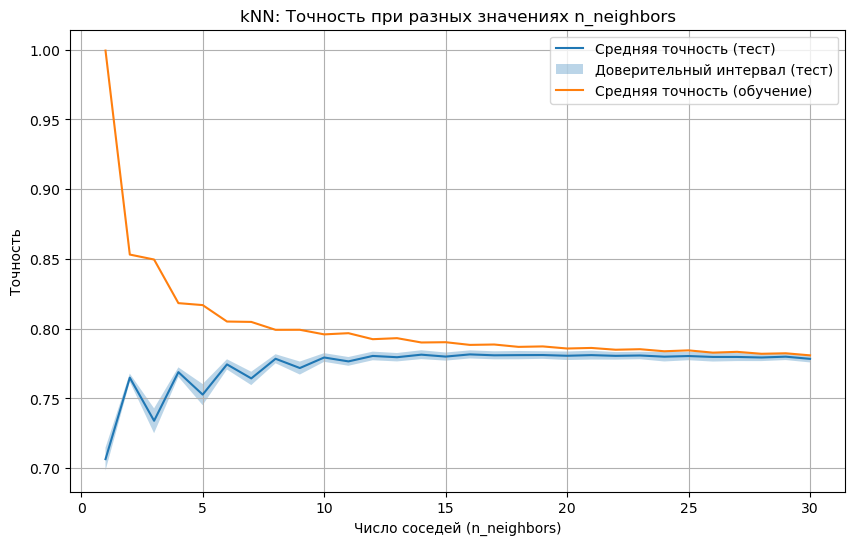

Оптимальные параметры для kNN: {'knn__n_neighbors': 16}
Лучшая точность для kNN: 0.7815855306240932


In [54]:
# Построение графика для kNN
plt.figure(figsize=(10, 6))
plt.plot(knn_params['knn__n_neighbors'], 
         knn_grid.cv_results_['mean_test_score'], 
         label="Средняя точность (тест)")

plt.fill_between(knn_params['knn__n_neighbors'],
                 knn_grid.cv_results_['mean_test_score'] - knn_grid.cv_results_['std_test_score'],
                 knn_grid.cv_results_['mean_test_score'] + knn_grid.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")

plt.plot(knn_params['knn__n_neighbors'], 
         knn_grid.cv_results_['mean_train_score'], 
         label="Средняя точность (обучение)")


plt.xlabel("Число соседей (n_neighbors)")
plt.ylabel("Точность")
plt.title("kNN: Точность при разных значениях n_neighbors")
plt.legend()
plt.grid(True)
plt.show()

print(f"Оптимальные параметры для kNN: {knn_grid.best_params_}")
print(f"Лучшая точность для kNN: {knn_grid.best_score_}")

# SGD и GridSearch

In [55]:
# Pipeline и GridSearchCV для SGD
sgd_pipe = Pipeline([('sgd', SGDClassifier(max_iter=10000, tol=1e-3, random_state=42))])
sgd_params = {'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']}

In [56]:
sgd_grid = GridSearchCV(sgd_pipe, sgd_params, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                        scoring='accuracy',
                        return_train_score=True)
sgd_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('sgd',
                                        SGDClassifier(max_iter=10000,
                                                      random_state=42))]),
             param_grid={'sgd__loss': ['hinge', 'log_loss', 'modified_huber',
                                       'squared_hinge', 'perceptron']},
             return_train_score=True, scoring='accuracy')

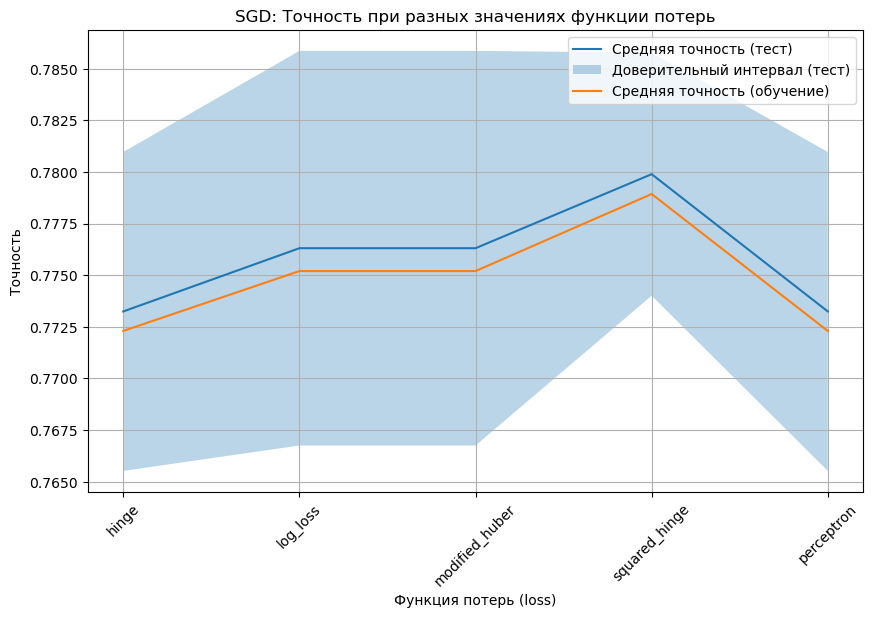

Оптимальные параметры для SGD: {'sgd__loss': 'squared_hinge'}
Лучшая точность для SGD: 0.7798911464121089


In [57]:
# Построение графика для SGD
plt.figure(figsize=(10, 6))
plt.plot(sgd_params['sgd__loss'], sgd_grid.cv_results_['mean_test_score'], label="Средняя точность (тест)")
plt.fill_between(sgd_params['sgd__loss'],
                 sgd_grid.cv_results_['mean_test_score'] - sgd_grid.cv_results_['std_test_score'],
                 sgd_grid.cv_results_['mean_test_score'] + sgd_grid.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")
plt.plot(sgd_params['sgd__loss'], sgd_grid.cv_results_['mean_train_score'], label="Средняя точность (обучение)")
plt.xlabel("Функция потерь (loss)")
plt.ylabel("Точность")
plt.title("SGD: Точность при разных значениях функции потерь")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


print(f"Оптимальные параметры для SGD: {sgd_grid.best_params_}")
print(f"Лучшая точность для SGD: {sgd_grid.best_score_}")

Что вы можете сказать о получившихся графиках?

**(0.75 балла)** Также подберём параметр регуляризации C в алгоритмах LogisticRegression и SVC.

</font><font color='Blue'><b>Лучшая точность для kNN: 0.7815855306240932
Лучшая точность для SGD: 0.7798911464121089

Точность для двух моделей получилась сопостовимая, у KNN незначительно выше. При этом обучение модели KNN заняло значительно больше времени - 32 сек против 2.4 сек у SGD</b></font><br>

# LogisticRegression

In [58]:
lr_pipe = Pipeline([('lr', LogisticRegression(solver='liblinear', random_state=42))])
lr_params = {'lr__C': np.logspace(-5, 5, 11)} # Используем логарифмическую шкалу для C

In [59]:
lr_grid = GridSearchCV(lr_pipe, lr_params, 
                       cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                       scoring='accuracy',
                      return_train_score=True)
lr_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('lr',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             return_train_score=True, scoring='accuracy')

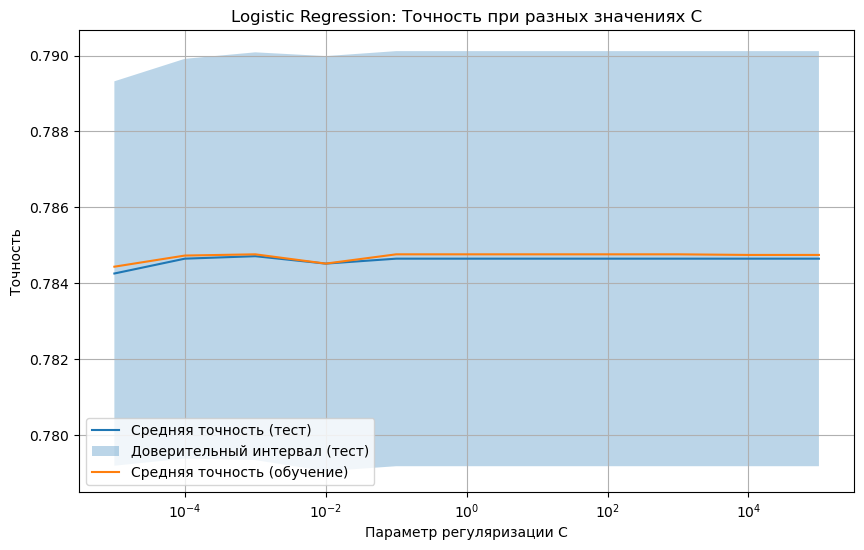

Оптимальные параметры для Logistic Regression: {'lr__C': 0.001}
Лучшая точность для Logistic Regression: 0.7847131820463753


In [60]:
# Построение графика для Logistic Regression
plt.figure(figsize=(10, 6))
plt.semilogx(lr_params['lr__C'], lr_grid.cv_results_['mean_test_score'], label="Средняя точность (тест)")
plt.fill_between(lr_params['lr__C'],
                 lr_grid.cv_results_['mean_test_score'] - lr_grid.cv_results_['std_test_score'],
                 lr_grid.cv_results_['mean_test_score'] + lr_grid.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")
plt.semilogx(lr_params['lr__C'], lr_grid.cv_results_['mean_train_score'], label="Средняя точность (обучение)")
plt.xlabel("Параметр регуляризации C")
plt.ylabel("Точность")
plt.title("Logistic Regression: Точность при разных значениях C")
plt.legend()
plt.grid(True)
plt.show()

print(f"Оптимальные параметры для Logistic Regression: {lr_grid.best_params_}")
print(f"Лучшая точность для Logistic Regression: {lr_grid.best_score_}")

**(0.75 балла)** Изучите документацию по алгоритму [Naive Bayes Classifier](https://scikit-learn.org/stable/modules/naive_bayes.html) и подберите возможные гиперпараметры для этого алгоритма.

# Naive Bayes Classifier

In [61]:
bnb_pipe = Pipeline([ ('bnb',BernoulliNB())])

bnb_params = {'bnb__alpha': np.logspace(-5, 0, 6)} # Подбор alpha

In [62]:
bnb_grid = GridSearchCV(bnb_pipe, 
                        bnb_params, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        scoring='accuracy')
bnb_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('bnb', BernoulliNB())]),
             param_grid={'bnb__alpha': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00])},
             scoring='accuracy')

In [63]:
print(f"Оптимальные параметры для BernoulliNB: {bnb_grid.best_params_}")
print(f"Лучшая точность для BernoulliNB: {bnb_grid.best_score_}")

Оптимальные параметры для BernoulliNB: {'bnb__alpha': 1e-05}
Лучшая точность для BernoulliNB: 0.7667291386068312


</font><font color='Blue'><b>
Лучшая точность для kNN: 0.7815855306240932

Лучшая точность для SGD: 0.7798911464121089

Лучшая точность для Logistic Regression: 0.7847131820463753

Лучшая точность для BernoulliNB: 0.7667291386068312

Точность всех моделей очень близка, хуже всего получился Naive Bayes
</b></font><br>

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**(0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

<Axes: >

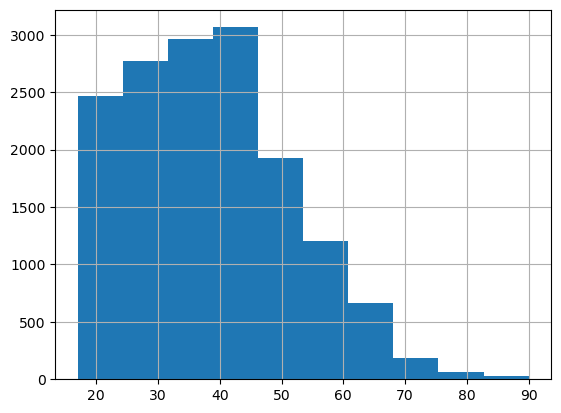

In [64]:
X['age'].hist()

<Axes: >

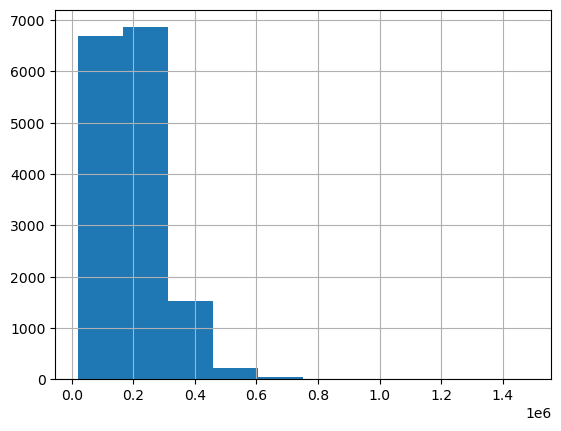

In [65]:
X['fnlwgt'].hist()

<Axes: >

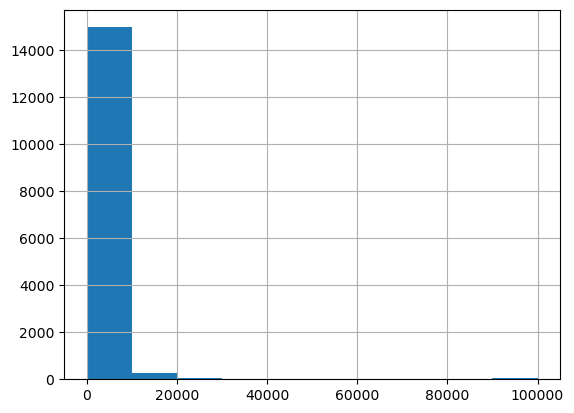

In [66]:
X['capital-gain'].hist()

Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?




Алгоритмы, чувствительные к масштабированию:

* kNN: kNN вычисляет расстояния между точками данных. Если признаки имеют разные масштабы, признаки с большим масштабом будут доминировать при вычислении расстояния, что может привести к искаженным результатам.

* SGD Classifier, Logistic Regression, SVC (с линейным ядром): Эти алгоритмы основаны на градиентном спуске и чувствительны к масштабированию признаков. Если признаки имеют разные масштабы, градиентный спуск может сходиться медленнее или вообще не достичь оптимального решения. Масштабирование обычно улучшает производительность этих алгоритмов. SVC с нелинейным ядром менее чувствителен к масштабированию, но оно все равно может быть полезным.

* Логистическая регрессия: Масштабирование данных для логистической регрессии улучшает интерпретируемость коэффициентов модели, делая их сравнимыми по величине.

Алгоритмы, менее чувствительные к масштабированию:

* Naive Bayes (GaussianNB): `GaussianNB` менее чувствителен к масштабированию, так как он моделирует каждое измерение (признак) независимо как гауссовское распределение. Масштабирование обычно не требуется, но иногда может немного улучшить результаты.
* Naive Bayes (BernoulliNB, MultinomialNB): `BernoulliNB` работает с бинарными данными, поэтому масштабирование не применяется. `MultinomialNB` требует неотрицательных целочисленных признаков, и масштабирование обычно не рекомендуется, если ваши данные уже представлены в виде подсчетов. Если ваши данные не целые и неотрицательные, перед применением `MultinomialNB` обычно используется `MinMaxScaler` для преобразования данных в диапазон [0, 1].

В общем случае:

Хорошей практикой является масштабирование данных перед применением большинства алгоритмов машинного обучения, особенно если признаки имеют разные масштабы. Это может улучшить производительность, скорость сходимости и интерпретируемость модели. Экспериментируйте с разными методами масштабирования (`StandardScaler`, `MinMaxScaler`, `RobustScaler`) для достижения наилучших результатов.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**(1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

# Масштабированный KNN

In [67]:
# Pipeline и GridSearchCV для kNN
knn_scaled_pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_params = {'knn__n_neighbors': range(1, 31)}

In [68]:
knn_scaled_grid = GridSearchCV(knn_scaled_pipe, 
                        knn_params, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        return_train_score=True)
knn_scaled_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 31)},
             return_train_score=True)

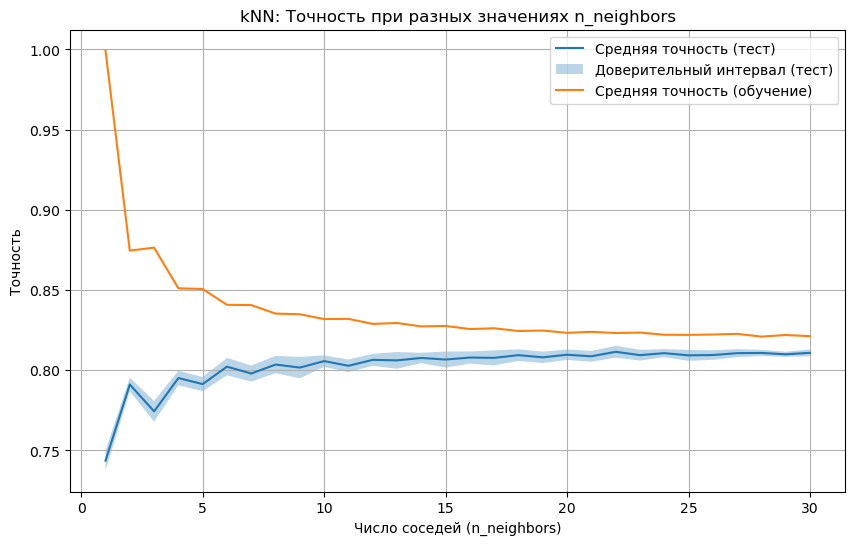

Оптимальные параметры для scaled kNN: {'knn__n_neighbors': 22}
Лучшая точность для scaled kNN: 0.8114942213986029


In [69]:
# Построение графика для kNN
plt.figure(figsize=(10, 6))
plt.plot(knn_params['knn__n_neighbors'], 
         knn_scaled_grid.cv_results_['mean_test_score'], 
         label="Средняя точность (тест)")

plt.fill_between(knn_params['knn__n_neighbors'],
                 knn_scaled_grid.cv_results_['mean_test_score'] - knn_scaled_grid.cv_results_['std_test_score'],
                 knn_scaled_grid.cv_results_['mean_test_score'] + knn_scaled_grid.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")

plt.plot(knn_params['knn__n_neighbors'], 
         knn_scaled_grid.cv_results_['mean_train_score'], 
         label="Средняя точность (обучение)")


plt.xlabel("Число соседей (n_neighbors)")
plt.ylabel("Точность")
plt.title("kNN: Точность при разных значениях n_neighbors")
plt.legend()
plt.grid(True)
plt.show()

print(f"Оптимальные параметры для scaled kNN: {knn_scaled_grid.best_params_}")
print(f"Лучшая точность для scaled kNN: {knn_scaled_grid.best_score_}")

# Масштабированный SGD

In [70]:
# Pipeline и GridSearchCV для SGD
sgd_scaled_pipe = Pipeline([('scaler', StandardScaler()), 
                     ('sgd', SGDClassifier(max_iter=10000, tol=1e-3, random_state=42))])
sgd_params = {'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']}

In [71]:
sgd_scaled_grid = GridSearchCV(sgd_scaled_pipe, sgd_params, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                        scoring='accuracy',
                        return_train_score=True)
sgd_scaled_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sgd',
                                        SGDClassifier(max_iter=10000,
                                                      random_state=42))]),
             param_grid={'sgd__loss': ['hinge', 'log_loss', 'modified_huber',
                                       'squared_hinge', 'perceptron']},
             return_train_score=True, scoring='accuracy')

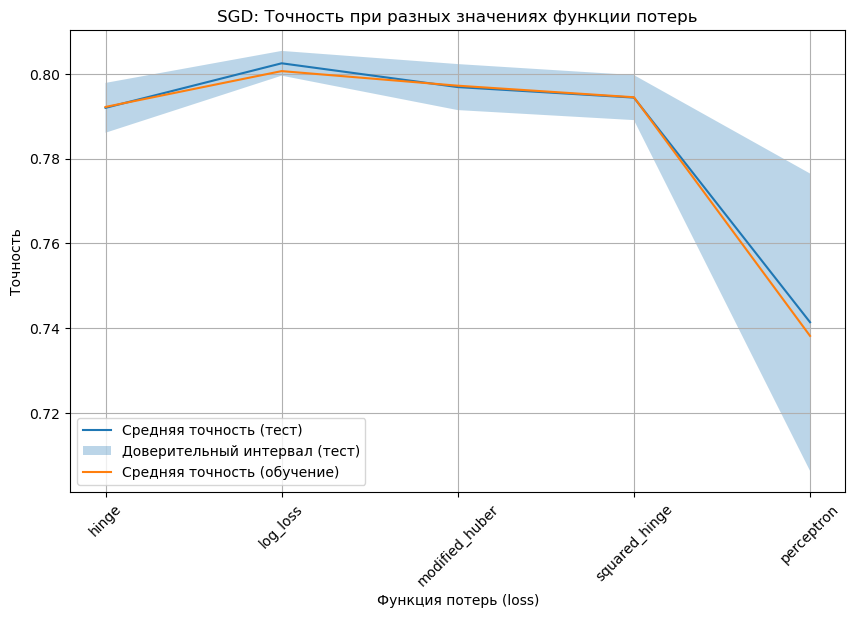

Оптимальные параметры для scaled SGD: {'sgd__loss': 'log_loss'}
Лучшая точность для scaled SGD: 0.8024371061672733


In [72]:
# Построение графика для SGD
plt.figure(figsize=(10, 6))
plt.plot(sgd_params['sgd__loss'], sgd_scaled_grid.cv_results_['mean_test_score'], label="Средняя точность (тест)")
plt.fill_between(sgd_params['sgd__loss'],
                 sgd_scaled_grid.cv_results_['mean_test_score'] - sgd_scaled_grid.cv_results_['std_test_score'],
                 sgd_scaled_grid.cv_results_['mean_test_score'] + sgd_scaled_grid.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")
plt.plot(sgd_params['sgd__loss'], sgd_scaled_grid.cv_results_['mean_train_score'], label="Средняя точность (обучение)")
plt.xlabel("Функция потерь (loss)")
plt.ylabel("Точность")
plt.title("SGD: Точность при разных значениях функции потерь")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


print(f"Оптимальные параметры для scaled SGD: {sgd_scaled_grid.best_params_}")
print(f"Лучшая точность для scaled SGD: {sgd_scaled_grid.best_score_}")

# Масштабированный LogisticRegression

In [73]:
lr_scaled_pipe = Pipeline([('scaler', StandardScaler()), 
                    ('lr', LogisticRegression(solver='liblinear', random_state=42))])
lr_params = {'lr__C': np.logspace(-5, 5, 11)} # Используем логарифмическую шкалу для C

In [74]:
lr_scaled_grid = GridSearchCV(lr_scaled_pipe, lr_params, 
                       cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                       scoring='accuracy',
                      return_train_score=True)
lr_scaled_grid.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             return_train_score=True, scoring='accuracy')

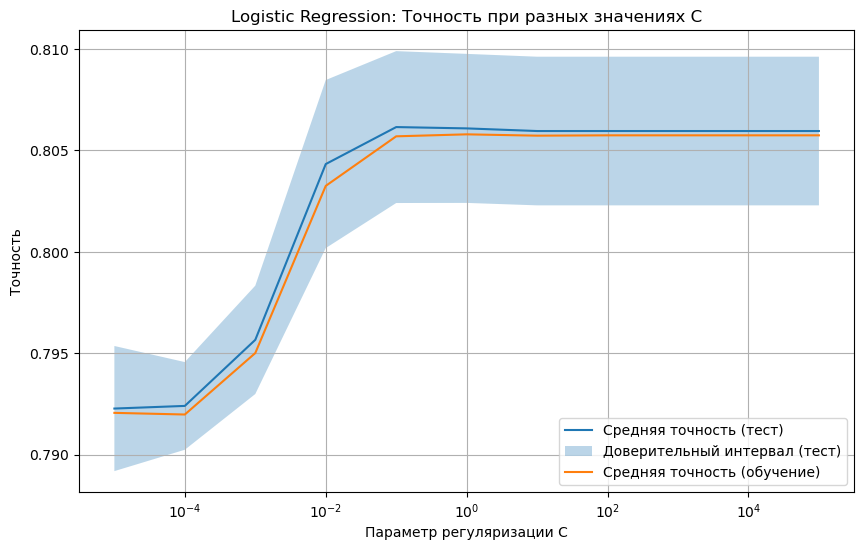

Оптимальные параметры для scaled Logistic Regression: {'lr__C': 0.1}
Лучшая точность для scaled Logistic Regression: 0.8061511192623938


In [75]:
# Построение графика для Logistic Regression
plt.figure(figsize=(10, 6))
plt.semilogx(lr_params['lr__C'], lr_scaled_grid.cv_results_['mean_test_score'], label="Средняя точность (тест)")
plt.fill_between(lr_params['lr__C'],
                 lr_scaled_grid.cv_results_['mean_test_score'] - lr_scaled_grid.cv_results_['std_test_score'],
                 lr_scaled_grid.cv_results_['mean_test_score'] + lr_scaled_grid.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")
plt.semilogx(lr_params['lr__C'], lr_scaled_grid.cv_results_['mean_train_score'], label="Средняя точность (обучение)")
plt.xlabel("Параметр регуляризации C")
plt.ylabel("Точность")
plt.title("Logistic Regression: Точность при разных значениях C")
plt.legend()
plt.grid(True)
plt.show()

print(f"Оптимальные параметры для scaled Logistic Regression: {lr_scaled_grid.best_params_}")
print(f"Лучшая точность для scaled Logistic Regression: {lr_scaled_grid.best_score_}")

# Масштабированный Naive Bayes

In [76]:
# Pipeline для MultinomialNB (адаптируйте для других вариантов)

mnb_scaled_pipe = Pipeline([('scaler', MinMaxScaler()), # Масштабирование 0-1, важно для MultinomialNB!
                     ('mnb', MultinomialNB())])

mnb_params = {'mnb__alpha': np.logspace(-5, 0, 6)} # Подбор alpha

In [77]:
mnb_scaled_grid = GridSearchCV(mnb_scaled_pipe, mnb_params, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        scoring='accuracy', n_jobs=-1)
mnb_scaled_grid.fit(X, y) # X должен быть неотрицательным для MultinomialNB!


print(f"Оптимальные параметры для MultinomialNB: {mnb_scaled_grid.best_params_}")
print(f"Лучшая точность для MultinomialNB: {mnb_scaled_grid.best_score_}")

Оптимальные параметры для MultinomialNB: {'mnb__alpha': 1e-05}
Лучшая точность для MultinomialNB: 0.7475074799693902


Изменилось ли качество у некоторых алгоритмов?

In [78]:
models = [
    'KNN',
    'SGD',
    'LogRegr',
    'Naive Bayes'
]

not_scaled_best_score = [
    knn_grid.best_score_,
    sgd_grid.best_score_,
    lr_grid.best_score_,
    bnb_grid.best_score_
]

scaled_best_score = [
    knn_scaled_grid.best_score_,
    sgd_scaled_grid.best_score_,
    lr_scaled_grid.best_score_,
    mnb_scaled_grid.best_score_
]

model_data = {
    'Модель': models,
    'Best score': not_scaled_best_score,
    'Best score (scaled)': scaled_best_score
}

models_df = pd.DataFrame(model_data)

models_df['change, %'] = (models_df['Best score (scaled)'] - models_df['Best score'])/ models_df['Best score'] * 100

In [79]:
models_df

,Модель,Best score,Best score (scaled),"change, %"
0,KNN,0.781586,0.811494,3.826669
1,SGD,0.779891,0.802437,2.890911
2,LogRegr,0.784713,0.806151,2.731946
3,Naive Bayes,0.766729,0.747507,-2.506969


С учетом масштабирования улучшились показатели моделей KNN, SGD, логистической регрессии (+3-4%)

**(1,5 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае, например:
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*

Для оставшихся трех алгоритмов самостоятельно определите, какие наборы гиперпараметров необходимо перебирать и осуществите перебор.

Обратите внимание, что эта операция может быть ресурсо- и трудоемкой.

Какой из алгоритмов имеет наилучшее качество? 

**(0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**(0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [80]:
X_all_features = pd.get_dummies(data)

In [81]:
X_all_features

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male
0,34,284843,9,594,0,60,False,True,False,False,...,False,False,False,False,False,True,False,False,False,True
1,40,190290,10,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
2,36,177858,13,0,0,40,False,True,False,False,...,True,False,False,False,False,False,False,True,False,True
3,22,184756,10,0,0,30,False,False,True,False,...,True,False,False,False,False,False,False,True,True,False
4,47,149700,13,15024,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16275,25,514716,13,0,0,40,False,True,False,False,...,True,False,False,False,False,True,False,False,True,False
16276,32,207668,13,15024,0,45,False,False,True,False,...,False,False,False,False,False,False,False,True,False,True
16277,27,104457,13,0,0,40,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
16278,59,268700,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True


# Масштабированный KNN c категориальными признаками

In [82]:
# Pipeline и GridSearchCV для kNN
knn_scaled_pipe_all_features = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
knn_params = {'knn__n_neighbors': range(1, 31)}

In [83]:
knn_scaled_grid_all_features = GridSearchCV(knn_scaled_pipe_all_features, 
                        knn_params, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        return_train_score=True)
knn_scaled_grid_all_features.fit(X_all_features, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': range(1, 31)},
             return_train_score=True)

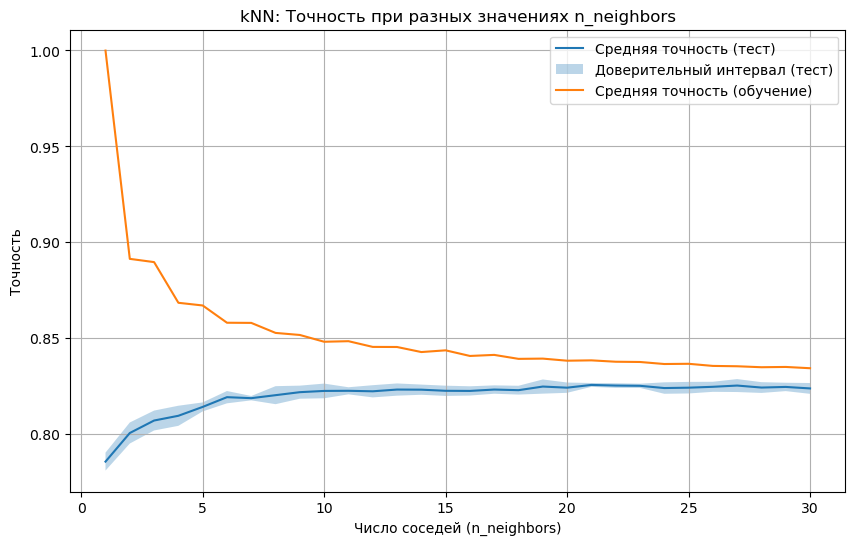

Оптимальные параметры для scaled kNN: {'knn__n_neighbors': 21}
Лучшая точность для scaled kNN: 0.8255034743781199


In [84]:
# Построение графика для kNN
plt.figure(figsize=(10, 6))
plt.plot(knn_params['knn__n_neighbors'], 
         knn_scaled_grid_all_features.cv_results_['mean_test_score'], 
         label="Средняя точность (тест)")

plt.fill_between(knn_params['knn__n_neighbors'],
                 knn_scaled_grid_all_features.cv_results_['mean_test_score'] - knn_scaled_grid_all_features.cv_results_['std_test_score'],
                 knn_scaled_grid_all_features.cv_results_['mean_test_score'] + knn_scaled_grid_all_features.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")

plt.plot(knn_params['knn__n_neighbors'], 
         knn_scaled_grid_all_features.cv_results_['mean_train_score'], 
         label="Средняя точность (обучение)")


plt.xlabel("Число соседей (n_neighbors)")
plt.ylabel("Точность")
plt.title("kNN: Точность при разных значениях n_neighbors")
plt.legend()
plt.grid(True)
plt.show()

print(f"Оптимальные параметры для scaled kNN: {knn_scaled_grid_all_features.best_params_}")
print(f"Лучшая точность для scaled kNN: {knn_scaled_grid_all_features.best_score_}")

# Масштабированный SGD c категориальными признаками

In [85]:
# Pipeline и GridSearchCV для SGD
sgd_scaled_pipe_all_features = Pipeline([('scaler', StandardScaler()), 
                     ('sgd', SGDClassifier(max_iter=10000, tol=1e-3, random_state=42))])
sgd_params = {'sgd__loss': ['hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron']}

In [86]:
sgd_scaled_grid_all_features = GridSearchCV(sgd_scaled_pipe_all_features, sgd_params, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                        scoring='accuracy',
                        return_train_score=True)
sgd_scaled_grid_all_features.fit(X_all_features, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('sgd',
                                        SGDClassifier(max_iter=10000,
                                                      random_state=42))]),
             param_grid={'sgd__loss': ['hinge', 'log_loss', 'modified_huber',
                                       'squared_hinge', 'perceptron']},
             return_train_score=True, scoring='accuracy')

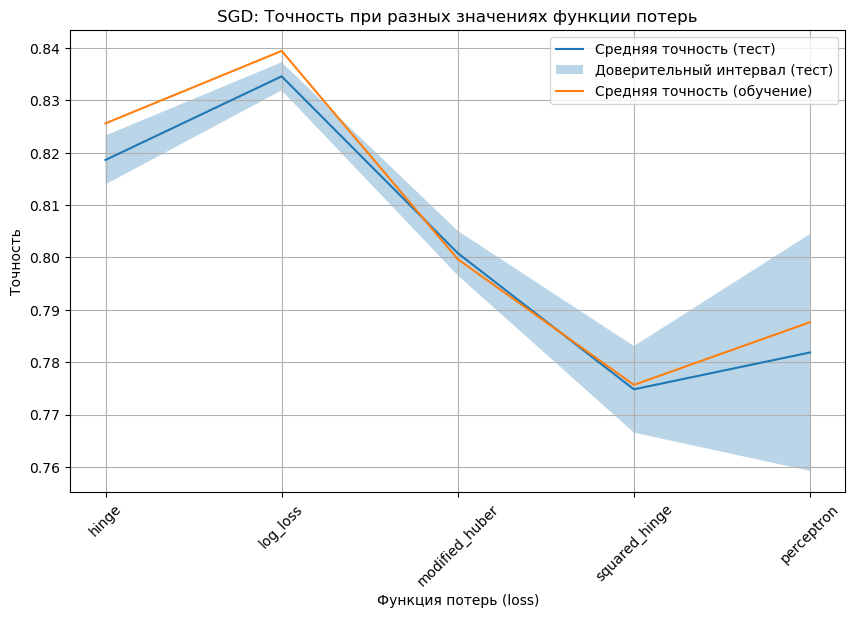

Оптимальные параметры для scaled SGD: {'sgd__loss': 'log_loss'}
Лучшая точность для scaled SGD: 0.8345604410183585


In [87]:
# Построение графика для SGD
plt.figure(figsize=(10, 6))
plt.plot(sgd_params['sgd__loss'], sgd_scaled_grid_all_features.cv_results_['mean_test_score'], label="Средняя точность (тест)")
plt.fill_between(sgd_params['sgd__loss'],
                 sgd_scaled_grid_all_features.cv_results_['mean_test_score'] - sgd_scaled_grid_all_features.cv_results_['std_test_score'],
                 sgd_scaled_grid_all_features.cv_results_['mean_test_score'] + sgd_scaled_grid_all_features.cv_results_['std_test_score'], alpha=0.3,
                 label="Доверительный интервал (тест)")
plt.plot(sgd_params['sgd__loss'], sgd_scaled_grid_all_features.cv_results_['mean_train_score'], label="Средняя точность (обучение)")
plt.xlabel("Функция потерь (loss)")
plt.ylabel("Точность")
plt.title("SGD: Точность при разных значениях функции потерь")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


print(f"Оптимальные параметры для scaled SGD: {sgd_scaled_grid_all_features.best_params_}")
print(f"Лучшая точность для scaled SGD: {sgd_scaled_grid_all_features.best_score_}")

# Масштабированный Logistic Regression c категориальными признаками

In [88]:
lr_scaled_pipe_all_features = Pipeline([('scaler', StandardScaler()), 
                    ('lr', LogisticRegression(solver='liblinear', random_state=42))])
lr_params = {'lr__C': np.logspace(-5, 5, 11)} # Используем логарифмическую шкалу для C

In [89]:
lr_scaled_grid_all_features = GridSearchCV(lr_scaled_pipe_all_features, lr_params, 
                       cv=KFold(n_splits=5, shuffle=True, random_state=42), 
                       scoring='accuracy',
                      return_train_score=True)
lr_scaled_grid_all_features.fit(X_all_features, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lr',
                                        LogisticRegression(random_state=42,
                                                           solver='liblinear'))]),
             param_grid={'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05])},
             return_train_score=True, scoring='accuracy')

In [90]:
print(f"Оптимальные параметры для scaled Logistic Regression: {lr_scaled_grid_all_features.best_params_}")
print(f"Лучшая точность для scaled Logistic Regression: {lr_scaled_grid_all_features.best_score_}")

Оптимальные параметры для scaled Logistic Regression: {'lr__C': 1.0}
Лучшая точность для scaled Logistic Regression: 0.8444645891509399


# Масштабированный Naive Bayes c категориальными признаками

In [91]:
# Pipeline для MultinomialNB (адаптируйте для других вариантов)

mnb_scaled_pipe_all_features = Pipeline([('scaler', MinMaxScaler()), # Масштабирование 0-1, важно для MultinomialNB!
                     ('mnb', MultinomialNB())])

mnb_params = {'mnb__alpha': np.logspace(-5, 0, 6)} # Подбор alpha

In [92]:
mnb_scaled_grid_all_features = GridSearchCV(mnb_scaled_pipe_all_features, mnb_params, cv=KFold(n_splits=5, shuffle=True, random_state=42),
                        scoring='accuracy', n_jobs=-1)
mnb_scaled_grid_all_features.fit(X_all_features, y) # X должен быть неотрицательным для MultinomialNB!


print(f"Оптимальные параметры для MultinomialNB: {mnb_scaled_grid_all_features.best_params_}")
print(f"Лучшая точность для MultinomialNB: {mnb_scaled_grid_all_features.best_score_}")

Оптимальные параметры для MultinomialNB: {'mnb__alpha': 1e-05}
Лучшая точность для MultinomialNB: 0.7912947272451317


In [93]:
models = [
    'KNN',
    'SGD',
    'LogRegr',
    'Naive Bayes'
]

not_scaled_best_score = [
    knn_grid.best_score_,
    sgd_grid.best_score_,
    lr_grid.best_score_,
    bnb_grid.best_score_
]

scaled_best_score = [
    knn_scaled_grid.best_score_,
    sgd_scaled_grid.best_score_,
    lr_scaled_grid.best_score_,
    mnb_scaled_grid.best_score_
]

all_features_best_score = [
    knn_scaled_grid_all_features.best_score_,
    sgd_scaled_grid_all_features.best_score_,
    lr_scaled_grid_all_features.best_score_,
    mnb_scaled_grid_all_features.best_score_
]

model_data = {
    'Модель': models,
    'Best score': not_scaled_best_score,
    'Best score (scaled)': scaled_best_score,
    'Best score (all features)': all_features_best_score
}

models_df = pd.DataFrame(model_data)

#models_df['change, %'] = (models_df['Best score (scaled)'] - models_df['Best score'])/ models_df['Best score'] * 100

In [94]:
models_df

,Модель,Best score,Best score (scaled),Best score (all features)
0,KNN,0.781586,0.811494,0.825503
1,SGD,0.779891,0.802437,0.834560
2,LogRegr,0.784713,0.806151,0.844465
3,Naive Bayes,0.766729,0.747507,0.791295


При добавлении категориальных признаков улучшились показатели всех моделей. Существенней всего улучшилась SGD и логистическая регрессия.

Так как после кодирования признаков получилось достаточно много, в этой работе мы не будем добавлять их и подбирать заново оптимальные гиперпараметры. 

**(0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [95]:
#your code here

Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?

## Смешивание моделей

Во всех предыдущих пунктах мы получили много хороших моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и логистическая регрессия). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**(1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

In [96]:
#your code here

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**(1 балл)** Для каждого типа классификатора (kNN, SGD classifier и т.д.), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

In [97]:
#your code here